# Create wind stress and save it in directory INPUT/ as a nc file
 - Used to run MOM6 as one of the initial conditions.
 - Wind forcing is independent of type of vertical coordinate.


For the model, specify the following in the MOM_input file:

WIND_CONFIG = "file"             !   \
WIND_FILE = "forcing.nc"           ! default = "topog.nc"\
                                 ! The file from which the bathymetry is read.\
WINDSTRESS_X_VAR = "stress_x"   ! default = "STRESS_X"\
                                ! The name of the x-wind stress variable in WIND_FILE.\
WINDSTRESS_Y_VAR = "stress_y"   ! default = "STRESS_Y"

In [1]:
clear
homedir = getenv('HOME');
workdir = getenv('WORK');
scradir = getenv('SCRATCH');
addpath(genpath([homedir '/work_MOM']));
addpath(genpath([homedir '/mytoolbox']));
addpath(genpath([homedir '/MyFuncs']));

In [2]:
% create a grid on which the topo is defined: either read from data or create on your own
% % 1. read from data
% grid_dir = [scradir '/subme_model/'];  
% [grid, ~, ~] = read_grid_MOM([grid_dir '']); 
% ds_IC = ncstruct([grid_dir '/Initial_state.nc']);

% 2. create
delda_m = 2000; % [m] grid spacing
xlim = [0 400]; % km
ylim = [0 200];
[nih, njh] = deal((xlim(2)-xlim(1))*1e3/delda_m, (ylim(2)-ylim(1))*1e3/delda_m)
% xlim = [0 delda_m*nih/1e3]; % km
% ylim = [0 delda_m*njh/1e3];
grid = build_grid_MOM(nih,njh,xlim,ylim);


nih =

   200


njh =

   100



## create a zonal sin wind

In [3]:
tau0 = 0.20; % [N/m2] mag of wind

jmid_u = 1 + floor((grid.nju - 1) / 2);
midlat_u = grid.lath(jmid_u); % NOTE: geographic latitude of the (0 curl) axis of the wind stress

% wind stress at u- and v- grids [N/m2]
rad_u = grid.geolatu - midlat_u;
taux = 0.5*tau0*( 1.0 + cos( 2*pi*rad_u/grid.Ly));
tauy = zeros(grid.niv,grid.njv);

% wind stress curl on q-grid & p-
curl_wind = calc_curl_CG(taux,tauy,grid.dxBu,grid.dyBu);
curl_wind_p = curl_wind(1:end-1, 1:end-1);

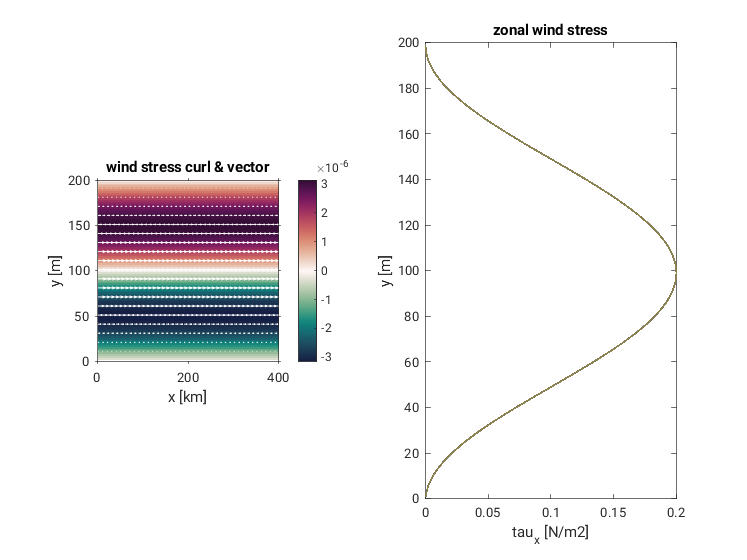

In [4]:
[taux_p, tauy_p] = uv2p_CG(taux, tauy);
[x, y] = deal(grid.lonh, grid.lath);
f_do = curl_wind_p;
figure
subplot(121)
imagescn(x, y, f_do');
hold on
dx_plt = 5; dy_plt = 5;
[ii,jj] = deal(1:dx_plt:grid.nih, 1:dy_plt:grid.njh);
quiver(grid.geolon(ii,jj),grid.geolat(ii,jj),taux_p(ii,jj),tauy_p(ii,jj),'LineWidth',.7,'Color','w');
cb = colorbar;
axis square
set(gca,'tickdir','out');
cmocean('curl')
title('wind stress curl & vector')
xlabel('x [km]'); ylabel('y [m]')

% figure
subplot(122)
plot(taux,grid.lath)
title('zonal wind stress')
xlabel('tau_x [N/m2]')
ylabel('y [m]')

set(gcf,'PaperPositionMode','auto'); 
% exportgraphics(gcf,['wind.png'], 'BackgroundColor','white','ContentType','image','resolution',400)


## save the wind

In [5]:
[xu, yu] = deal(grid.lonq, grid.lath);
[xv, yv] = deal(grid.lonh, grid.latq);


savefnm = 'INPUT_2km_x400kmy200km/forcingWIND.nc';
ncbuild(savefnm, xu, 'name', 'xq', 'dimnames', {'xq'}, ...
    'varatts', {'long_name', 'longitude at cell edges', 'units', 'km'});
ncbuild(savefnm, yv, 'name', 'yq', 'dimnames', {'yq'}, ...
    'varatts', {'long_name', 'latitude at cell edges', 'units', 'km'});
ncbuild(savefnm, xv, 'name', 'xh', 'dimnames', {'xh'}, ...
    'varatts', {'long_name', 'longitude at cell centers', 'units', 'km'});
ncbuild(savefnm, yu, 'name', 'yh', 'dimnames', {'yh'}, ...
    'varatts', {'long_name', 'latitude at cell centers', 'units', 'km'});
ncbuild(savefnm, 1, 'name', 'Time', 'dimnames', {'Time'}, 'unlimited', {'Time'} );
% 
ncbuild(savefnm, taux, 'name', 'stress_x', 'dimnames', {'xq','yh','Time'}, ...
    'varatts', {'long_name', 'x-wind stress', 'units', 'N/m^2'});
ncbuild(savefnm, tauy, 'name', 'stress_y', 'dimnames', {'xh','yq','Time'}, ...
    'varatts', {'long_name', 'y-wind stress', 'units', 'N/m^2'});   
    
ncdisp(savefnm)

Source:
           /glade/u/home/yueyanglu/work_mlmodel/INPUT_2km_x400kmy200km/forcingWIND.nc
Format:
           classic
Dimensions:
           xq   = 201
           yq   = 101
           xh   = 200
           yh   = 100
           Time = 1     (UNLIMITED)
Variables:
    xq      
           Size:       201x1
           Dimensions: xq
           Datatype:   double
           Attributes:
                       long_name = 'longitude at cell edges'
                       units     = 'km'
    yq      
           Size:       101x1
           Dimensions: yq
           Datatype:   double
           Attributes:
                       long_name = 'latitude at cell edges'
                       units     = 'km'
    xh      
           Size:       200x1
           Dimensions: xh
           Datatype:   double
           Attributes:
                       long_name = 'longitude at cell centers'
                       units     = 'km'
    yh      
           Size:       100x1
           Dimensions: 